# Analysis Long unbias sim
## 10 $\mu s$ of simulation

### Import needed modules and useful functions

In [1]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

### Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Results

In [3]:
set = "long_unbias/"

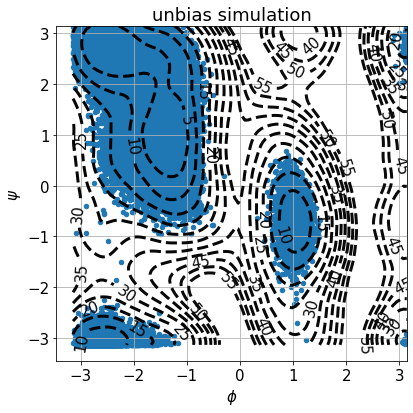

In [4]:

fig,ax = plt.subplots(1,1,figsize=(6,6))
data = load_dataframe(set+"COLVAR") 
descriptors_names = data.filter(regex='^d[^a-z]').columns.values 
#data.plot.scatter(y="psi",x="phi",ax=ax,c=color[k])
data.plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("../../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_title("unbias simulation")
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")
plt.tight_layout()
fig.savefig(set+"images/traj.png", dpi=300,facecolor="white", transparent=False)

500001
500001
6
times    974210.119656
dtype: float64 times    1555270.0
dtype: float64


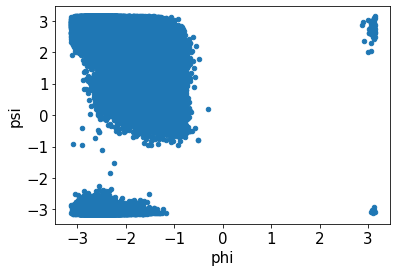

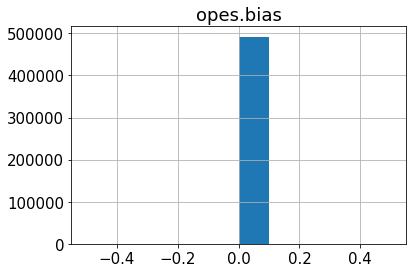

In [5]:
# I want to estimate the escape time from basin A to basin B and viceversa
# the idea is the following: take the time series and divide the time series in this way 
# interval for phi : [-pi,0] and [0,pi]
data = load_dataframe(set+"COLVAR")
data["opes.bias"] = np.zeros(len(data))
print(len(data))
data = data[:]
print(len(data))

indeces_basinA = ( (data["phi"] < 0) | (data["phi"] > 2.5) ) #& (data["psi"] < np.pi) & (data["psi"] > -1)  )
data[indeces_basinA].plot.scatter(x="phi",y="psi")
data[indeces_basinA].hist(column="opes.bias")
#print(data[indeces_basinA].index) 
#indeces_basinB = ( (data["phi"] > 0) & (data["phi"] < np.pi) )

time = 0
times = []
prev_index = -1 
dt = 20 #data["time"][1]-data["time"][0]
#print(data.head())
for index in (data[indeces_basinA].index):
    if index == prev_index+1:
        time += dt * np.exp( sim_parameters["beta"] * data["opes.bias"].to_numpy()[index] )
    else:
        times.append(time)
        time = 0
    prev_index = index
#print(times)
times = pd.DataFrame(times,columns=["times"])
print(len(times))
print( times.std() , times.mean())

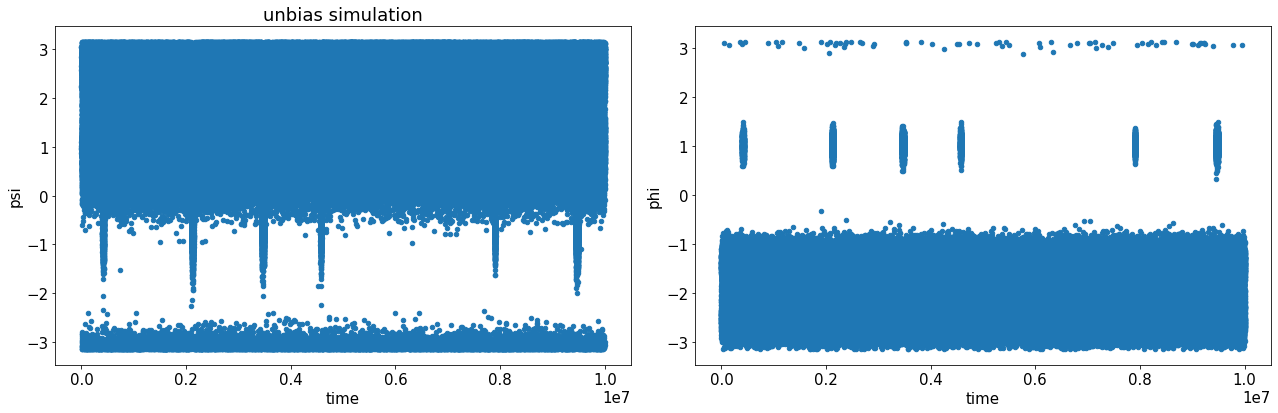

In [6]:
fig,axs = plt.subplots(1,2,figsize=(18,6))
data = load_dataframe(set+"COLVAR")
data.plot.scatter(x="time",y="psi",ax=axs[0])#, color=color[k])
data.plot.scatter(x="time",y="phi",ax=axs[1])#, color=color[k])

axs[0].set_title("unbias simulation")
plt.tight_layout()
fig.savefig(set+"images/psiphi.png", dpi=300,facecolor="white", transparent=False)

## Training

In [7]:
min_lag,max_lag = 20,100 #if stride is 100, 0.2,5 should be ok
n = 1 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
print(lags)
shuffle = False # if shuffle the data between batches
#-- train_datasets and valid_datasets list, it will be filled with new data every iteration
train_datasets = []
valid_datasets = []
# torch seed 
torch.manual_seed(21)

# load data
data = load_dataframe(set+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

#-- TRAINING PARAMETERS --#
n_output = 2 # 2 non linear combination of the descriptors  
n_input = len(descriptors_names) # can change..
train_parameters = {
              'descriptors': '^d[^a-z]', # can change during simulation
              'nodes':[n_input,30,30,n_output],
              'activ_type': 'tanh',#'relu','selu','tanh'
              'lag_time':10, 
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7, 
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':600,
              'batchsize': -1, #---> è da fare sul train loder and valid loader
              'es_patience':10,
              'es_consecutive':True,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              }

# how many data in single batch, batchsize
n_train = int( len(data)*train_parameters["trainsize"] )
n_valid = int( len(data)*(1-train_parameters["trainsize"])-int(10*max_lag) )
print("training samples: ",n_train, "\t validation samples", n_valid)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = data['time'].values
X = data[descriptors_names].values

[20.]
training samples:  350000 	 validation samples 149000


In [8]:
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,lag_time=np.round(lag,3),interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.001,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = set+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.377      -0.370      0.298  0.071  
100   -0.667      -0.661      0.582  0.080  
150   -0.840      -0.835      0.752  0.085  
200   -0.947      -0.943      0.858  0.088  
250   -1.005      -1.001      0.914  0.090  
300   -1.034      -1.031      0.942  0.092  
350   -1.050      -1.047      0.957  0.093  
400   -1.060      -1.057      0.967  0.093  
450   -1.067      -1.064      0.973  0.094  
INFO: Early stopping
479   -1.070      -1.067      0.976  0.094  
already exists


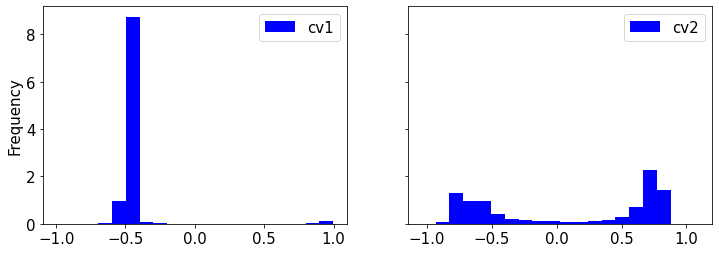

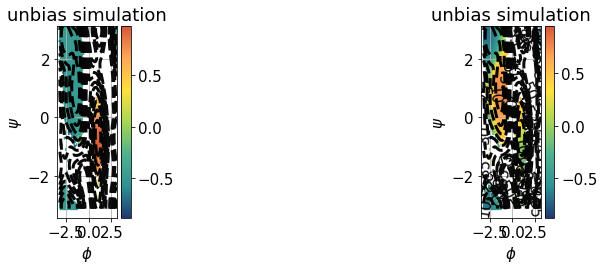

In [9]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b")

fig,ax = plt.subplots(1,2,figsize=(12,6))
data.plot.hexbin(y="psi",x="phi",C="cv1",cmap="fessa",ax=ax[0])#,ax=axs[k])
data.plot.hexbin(y="psi",x="phi",C="cv2",cmap="fessa",ax=ax[1])

fes = np.loadtxt("../../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_title("unbias simulation")
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_title("unbias simulation")
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")
fig.savefig(set+"images/cvs.png", dpi=300,facecolor="white", transparent=False)
plt.tight_layout()

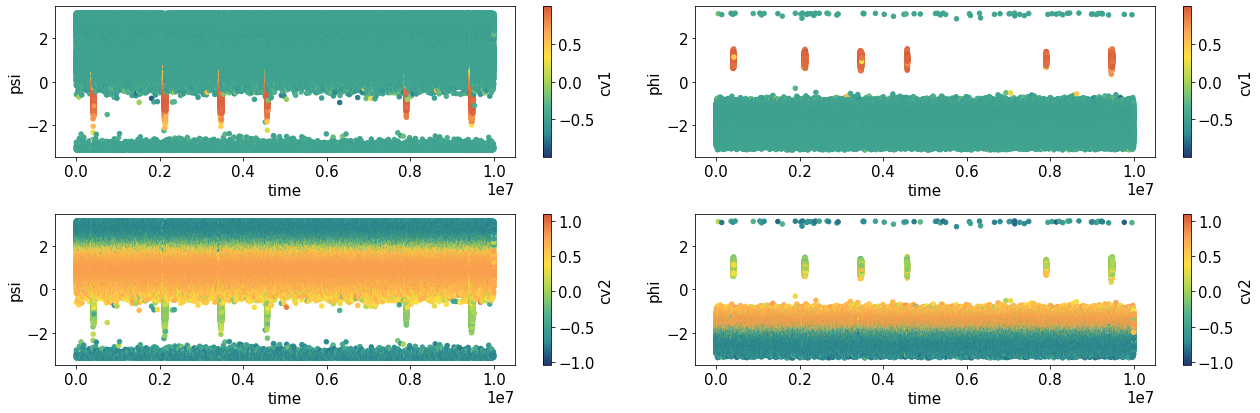

In [16]:
fig,axs = plt.subplots(2,2,figsize=(18,6))
data.plot.scatter(x="time",y="psi",c="cv1",cmap="fessa",ax=axs[0][0])
data.plot.scatter(x="time",y="phi",c="cv1",cmap="fessa",ax=axs[0][1])
data.plot.scatter(x="time",y="psi",c="cv2",cmap="fessa",ax=axs[1][0])
data.plot.scatter(x="time",y="phi",c="cv2",cmap="fessa",ax=axs[1][1])

plt.tight_layout()
fig.savefig(set+"images/psiphi_color.png", dpi=300,facecolor="white", transparent=False)

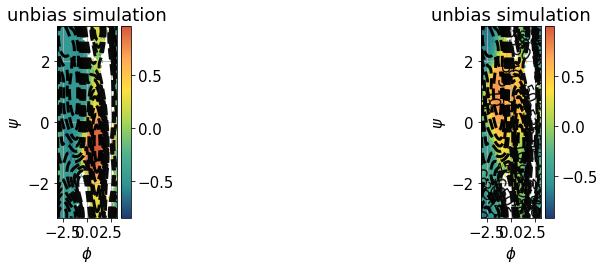

In [10]:
data_complete = load_dataframe("../../../angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy() 
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]   

fig,ax = plt.subplots(1,2,figsize=(12,6))
data_complete.plot.hexbin(y="psi",x="phi",C="cv1",cmap="fessa",ax=ax[0])#,ax=axs[k])
data_complete.plot.hexbin(y="psi",x="phi",C="cv2",cmap="fessa",ax=ax[1])

fes = np.loadtxt("../../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_title("unbias simulation")
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_title("unbias simulation")
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")
fig.savefig(set+"images/cvs_complete.png", dpi=300,facecolor="white", transparent=False)
plt.tight_layout()

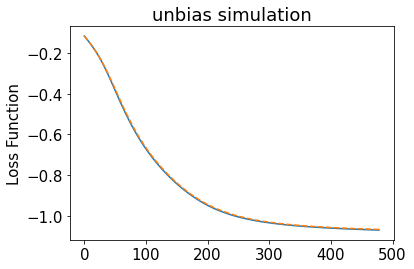

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,4))#,dpi=100)
plot_model_lossfunction(model,only_loss=ax)
ax.set_title("unbias simulation")

plt.tight_layout()

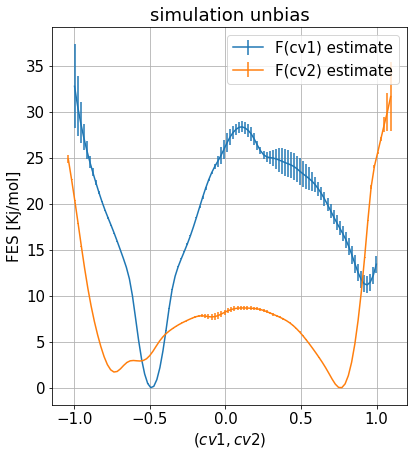

In [12]:
#-- estimation of Free Energy Surface --#
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
s = data.filter(regex="^cv").to_numpy()

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i],
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_title("simulation unbias")
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")
fig.savefig(set+"images/fescvs.png", dpi=300,facecolor="white", transparent=False)
plt.show()

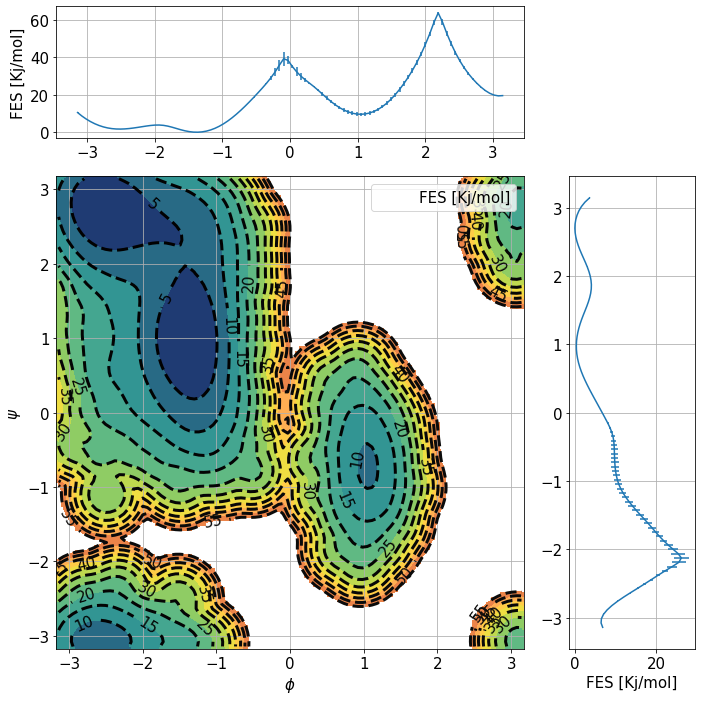

In [17]:
logweight = np.zeros(len(data))
gridspec_fes(s,logweight,sim_parameters)

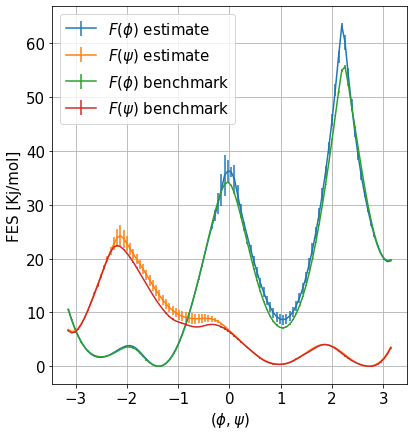

In [13]:
# estimation of free energy in phi and psi
s = data.filter(regex="^p").to_numpy()

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i],
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)

fes = np.loadtxt("../../../angles/fes1dphi.txt",delimiter=" ")
grid = np.loadtxt("../../../angles/grid1dphi.txt",delimiter=" ")
error = np.loadtxt("../../../angles/err1dphi.txt",delimiter=" ")
ax.errorbar(grid,fes,yerr=error)

fes = np.loadtxt("../../../angles/fes1dpsi.txt",delimiter=" ")
grid = np.loadtxt("../../../angles/grid1dpsi.txt",delimiter=" ")
error = np.loadtxt("../../../angles/err1dpsi.txt",delimiter=" ")
ax.errorbar(grid,fes,yerr=error)

ax.legend([r"$F(\phi)$ estimate",r"$F(\psi)$ estimate",r"$F(\phi)$ benchmark",r"$F(\psi)$ benchmark"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(\phi,\psi)$")
ax.set_ylabel("FES [Kj/mol]")
fig.savefig(set+"images/fespsiphi.png", dpi=300,facecolor="white", transparent=False)

In [14]:
''' free energy difference
res = 8.92808817900219

#-- with CLEAR set to 1000 I perform the estimation every ns --#
CLEAR=1000*50

deltaf = np.empty(0)
for el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):
    s = data["phi"][:el].values
    fes,grid,bounds,error = compute_fes(s,
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=2,
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=False)
    ind1 = (grid<0) 
    ind2 = (grid>0) 
    grid1 = grid[ ind1 ]
    grid2 = grid[ ind2 ] 
    I1 = integrate.trapz(np.exp(-fes[ind1]*sim_parameters["beta"]), grid1)
    I2 = integrate.trapz(np.exp(-fes[ind2]*sim_parameters["beta"]), grid2)
    
    deltaf = np.append(deltaf,(1/sim_parameters["beta"])*np.log(I1/I2))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(len(deltaf)),deltaf,label="Estimate")
res = np.full(len(deltaf),res)
err = np.full(len(deltaf),0.5*kb*sim_parameters["temp"])
ax.plot(np.arange(len(deltaf)),res,linestyle='--',linewidth=3,color="g",label="ref")
ax.fill_between(np.arange(len(deltaf)) , res-err, res+err , color="r",zorder=0,alpha=0.3)
ax.grid()
ax.legend()
ax.set_xlabel(r"$t$ [ps$\times$"+str(int(CLEAR/5))+"]")
ax.set_ylabel(r"$\Delta F$ [Kj/mol]")
txt = "shadow error of 0.5KbT"
# center text
fig.text(.5, -.03, txt, ha='center')
'''

' free energy difference\nres = 8.92808817900219\n\n#-- with CLEAR set to 1000 I perform the estimation every ns --#\nCLEAR=1000*50\n\ndeltaf = np.empty(0)\nfor el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):\n    s = data["phi"][:el].values\n    fes,grid,bounds,error = compute_fes(s,\n                                        temp=sim_parameters["temp"],\n                                        kbt=sim_parameters["kbt"],\n                                        blocks=2,\n                                        bandwidth=sim_parameters["bandwidth"],scale_by=\'range\',\n                                        plot=False)\n    ind1 = (grid<0) \n    ind2 = (grid>0) \n    grid1 = grid[ ind1 ]\n    grid2 = grid[ ind2 ] \n    I1 = integrate.trapz(np.exp(-fes[ind1]*sim_parameters["beta"]), grid1)\n    I2 = integrate.trapz(np.exp(-fes[ind2]*sim_parameters["beta"]), grid2)\n    \n    deltaf = np.append(deltaf,(1/sim_parameters["beta"])*np.log(I1/I2))\n\nfig,ax = plt.subplots(1,1,figsize=(8,6))\nax